# Background Energy Integration in Gammapy

This notebook shows a short check of the new background integration method. Instead of interpolating the differential counts, and integrate we compute the cumulative sum and interpolate it directly.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from gammapy.data import DataStore
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.cube import make_map_background_irf
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.utils.interpolation import ScaledRegularGridInterpolator
from gammapy.irf.background import Background3D

In [3]:
class Background3DNew(Background3D):
    def integrate_energy(self):
        axis_idx = [_.name for _ in self.data.axes].index("energy")
        energy_axes = self.data.axes[axis_idx]

        # the assumption here is, that the bkg model was computed by dividing by the bin width
        values = (self.data.data * energy_axes.bin_width[:, np.newaxis, np.newaxis]).to("s-1 sr-1")

        # add a zero entry, because the integral is zero at the minimal energy
        values_pad = np.insert(values, 0, 0, axis=axis_idx)
        values_cum = np.cumsum(values_pad, axis=axis_idx)

        values_scaled = (values_cum.max(axis=axis_idx) - values_cum) + 1 * u.Unit("s-1 sr-1")

        energy = energy_axes.bins
        return ScaledRegularGridInterpolator(
            points=(energy,),
            values=values_scaled,
            values_scale="log",
            points_scale=["log"],
            axis=0
        )

    def evaluate_integrate(
        self, fov_lon, fov_lat, energy_reco, method="linear", **kwargs
    ):
        e_min, e_max = energy_reco[:-1], energy_reco[1:]

        integrate = self.integrate_energy()
        int_min = integrate((e_min.squeeze(),), method=method)
        int_max = integrate((e_max.squeeze(),), method=method)
        values = int_min - int_max

        fov_lon_ = self.data.axes[1].lin_center()
        fov_lat_ = self.data.axes[2].lin_center()

        interp_fov = ScaledRegularGridInterpolator(
            values=values,
            points=(e_min.squeeze(), fov_lon_, fov_lat_)
        )
        return interp_fov((e_min, fov_lon, fov_lat)) 

In [4]:
store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps")

In [5]:
obs = store.get_observations([110380])[0]

In [6]:
bkg_3d = obs.bkg
e_edges = bkg_3d.data.axes[0].bins
e_center = bkg_3d.data.axes[0].log_center()

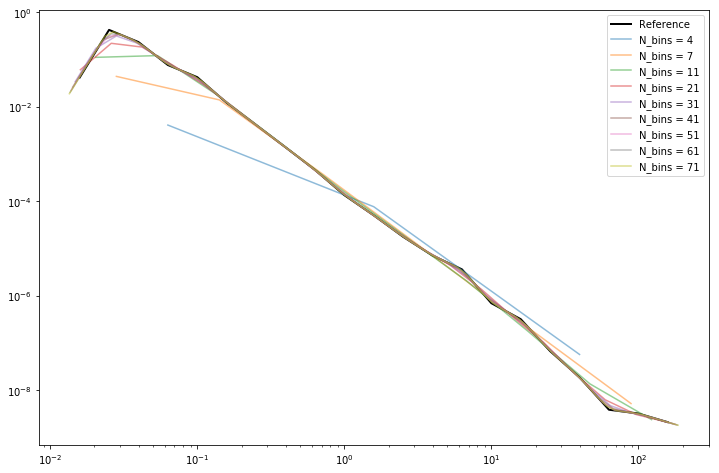

In [7]:
plt.figure(figsize=(12, 8))
bkg_profile = bkg_3d.evaluate(energy_reco=e_center, fov_lat=0 * u.deg, fov_lon=0 * u.deg)
plt.plot(e_center, bkg_profile, label="Reference", lw=2, color="k")

total_bkg = []
n_bins = [4, 7, 11, 21, 31, 41, 51, 61, 71]

for n_bin in n_bins:
    e_log_min = np.log10(e_edges[0].to_value("TeV"))
    e_log_max = np.log10(e_edges[-1].to_value("TeV"))
    e_n_bins = np.logspace(e_log_min, e_log_max, n_bin) * u.TeV
    e_n_bins_center = np.sqrt(e_n_bins[1:] * e_n_bins[:-1])
    
    bkg_profile_n_bins = bkg_3d.evaluate_integrate(
        energy_reco=e_n_bins,
        fov_lat=0 * u.deg,
        fov_lon=0 * u.deg
    )
    plt.plot(
        e_n_bins_center,
        (bkg_profile_n_bins / np.diff(e_n_bins)).to("sr-1 s-1 MeV-1"),
        alpha=0.5,
        label=f"N_bins = {n_bin}"
    )
    total_bkg.append(bkg_profile_n_bins.sum().to("s-1 sr-1"))
    
plt.loglog()
plt.legend()
plt.savefig(f"bkg-integration.png", dpi=300)

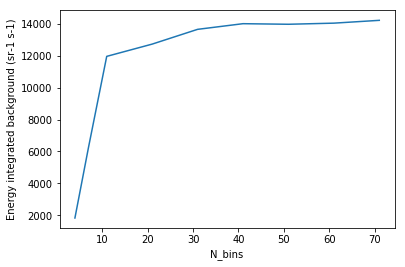

In [8]:
plt.plot(n_bins, u.Quantity(total_bkg))
plt.xlabel("N_bins")
plt.ylabel("Energy integrated background (sr-1 s-1)")
plt.savefig(f"bkg-integration.png", dpi=300)

In [9]:
skydir = SkyCoord(0, 0, frame="galactic", unit="deg")
energy_axes = MapAxis.from_bounds(0.1, 100, 4, name="energy", unit="TeV")
geom = WcsGeom.create(skydir=skydir, binsz=0.02, width=(8, 8), axes=[energy_axes])

In [10]:
map_bkg = make_map_background_irf(skydir, 1 * u.h, bkg_3d, geom)

In [11]:
bkg_3d_new = Background3DNew(
    energy_lo=bkg_3d.data.axes[0].lo,
    energy_hi=bkg_3d.data.axes[0].hi,
    fov_lon_lo=bkg_3d.data.axes[1].lo,
    fov_lon_hi=bkg_3d.data.axes[1].hi,
    fov_lat_lo=bkg_3d.data.axes[2].lo,
    fov_lat_hi=bkg_3d.data.axes[2].hi,
    data=bkg_3d.data.data,
)

In [12]:
map_bkg_new = make_map_background_irf(skydir, 1 * u.h, bkg_3d_new, geom)

TypeError: __init__() got an unexpected keyword argument 'axis'

In [ ]:
map_diff = (map_bkg_new - map_bkg)

In [ ]:
map_diff.plot_interactive(vmin=-0.001, vmax=0.001, cmap="coolwarm", add_cbar=True, stretch="linear")

In [ ]:
plt.figure(figsize=(12, 8))
bkg_profile = bkg_3d_new.evaluate(energy_reco=e_center, fov_lat=0 * u.deg, fov_lon=0 * u.deg)
plt.plot(e_center, bkg_profile, label="Reference", lw=2, color="k")

total_bkg = []
n_bins = [4, 7, 11, 21, 31, 41, 51, 61, 71]

for n_bin in n_bins:
    e_log_min = np.log10(e_edges[0].to_value("TeV"))
    e_log_max = np.log10(e_edges[-1].to_value("TeV") - 1)
    e_n_bins = np.logspace(e_log_min, e_log_max, n_bin) * u.TeV
    e_n_bins_center = np.sqrt(e_n_bins[1:] * e_n_bins[:-1])
    
    bkg_profile_n_bins = bkg_3d_new.evaluate_integrate(
        energy_reco=e_n_bins,
        fov_lat=0 * u.deg,
        fov_lon=0 * u.deg
    )
    plt.plot(
        e_n_bins_center,
        (bkg_profile_n_bins / np.diff(e_n_bins)).to("sr-1 s-1 MeV-1"),
        alpha=0.5,
        label=f"N_bins = {n_bin}"
    )
    total_bkg.append(bkg_profile_n_bins.sum().to("s-1 sr-1"))
    
plt.loglog()
plt.legend()
plt.savefig(f"bkg-integration.png", dpi=300)

In [ ]:
plt.plot(n_bins, u.Quantity(total_bkg))
plt.xlabel("N_bins")
plt.ylabel("Energy integrated background (sr-1 s-1)")
plt.savefig(f"bkg-integration.png", dpi=300)